In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    rotation_range=30,          # Rotate images randomly by up to 30 degrees
    width_shift_range=0.2,      # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,     # Shift images vertically by up to 20% of the height
    shear_range=0.2,            # Apply shear transformations
    zoom_range=0.3,             # Apply zoom transformations
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest',        # Fill new pixels with the nearest available pixel
    brightness_range=(0.5, 1.5),  # Adjust brightness of images
    validation_split=0.2        # Specify the validation split here
)

#Data preprocessing
test_datagen = ImageDataGenerator(
    rescale=1./255             # Rescale pixel values to [0, 1]
)

# Generating training data generator
training_set = train_datagen.flow_from_directory(
    'MalariaCells/training_set',  # Path to the training dataset
    target_size=(64, 64),      # Set the target size (width, height) for resizing
    batch_size=220,            # Number of images in each batch
    class_mode='binary',       # For binary classification
    subset='training'          # Subset of the data (training portion)
)

# Generating validation data generator
validation_set = train_datagen.flow_from_directory(
    'MalariaCells/training_set',  # Path to the training dataset
    target_size=(64, 64),      # Set the target size (width, height) for resizing
    batch_size=50,             # Number of images in each batch
    class_mode='binary',       # For binary classification
    subset='validation'        # Subset of the data (validation portion)
)

# Generating testing data generator
test_set = test_datagen.flow_from_directory(
    'MalariaCells/testing_set',  # Path to the testing dataset
    target_size=(64, 64),      # Set the target size (width, height) for resizing
    batch_size=150,            # Number of images in each batch
    class_mode='binary'        # For binary classification
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 15832 images belonging to 2 classes.


In [3]:
# Create a Sequential model
model = Sequential([
    # First Convolutional layer
    Conv2D(filters=16, kernel_size=(4, 4), input_shape=(64, 64, 3)),
    BatchNormalization(),  # Add BatchNormalization after Conv2D
    Activation('relu'),    # Add Activation layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling
    
    # Second Convolutional layer
    Conv2D(filters=32, kernel_size=(4, 4), kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Add BatchNormalization after Conv2D
    Activation('relu'),    # Add Activation layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling
    
    # Third Convolutional layer
    Conv2D(filters=64, kernel_size=(4, 4), kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Add BatchNormalization after Conv2D
    Activation('relu'),    # Add Activation layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling
    
    # Fourth Convolutional layer
    Conv2D(filters=128, kernel_size=(4, 4), kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Add BatchNormalization after Conv2D
    Activation('relu'),    # Add Activation layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling
    
    Flatten(),  # Flatten feature maps to 1D
    Dense(32, activation = "relu"), # Fully connected layer with 32 neurons and ReLU activation
    Dense(16, activation = "relu"), # Fully connected layer with 16 neurons and ReLU activation
    Dense(1, activation='sigmoid')  # Fully connected layer for binary classification
])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 16)        784       
                                                                 
 batch_normalization (Batch  (None, 61, 61, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 61, 61, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        8224      
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 32)        1

In [ ]:
# Compiling the model with Adam optimizer and metrics including accuracy and precision
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Define a callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Train the model using the training set and validate using the validation set
history = model.fit(training_set, epochs=20, validation_data=validation_set, callbacks=[reduce_lr])

Epoch 1/20
101/101 [==============================] - 102s 987ms/step - loss: 1.2512 - accuracy: 0.7628 - precision: 0.7349 - recall: 0.8222 - auc: 0.8434 - val_loss: 1.2498 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.7391 - lr: 0.0010
Epoch 2/20
101/101 [==============================] - 89s 888ms/step - loss: 0.4904 - accuracy: 0.8965 - precision: 0.8597 - recall: 0.9477 - auc: 0.9429 - val_loss: 1.2101 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.8365 - lr: 0.0010
Epoch 3/20
101/101 [==============================] - 90s 894ms/step - loss: 0.3713 - accuracy: 0.9065 - precision: 0.8722 - recall: 0.9526 - auc: 0.9486 - val_loss: 1.2777 - val_accuracy: 0.5229 - val_precision: 0.5117 - val_recall: 1.0000 - val_auc: 0.8896 - lr: 0.0010
Epoch 4/20
101/101 [==============================] - 92s 908ms/step - loss: 0.3279 - accuracy: 0.9108 - precision: 0.8775 - recall: 0.9550 - auc: 0.9518 - val_loss: 0.4429 - val_accu

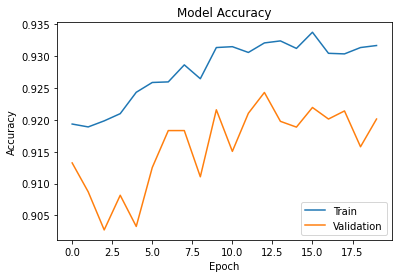

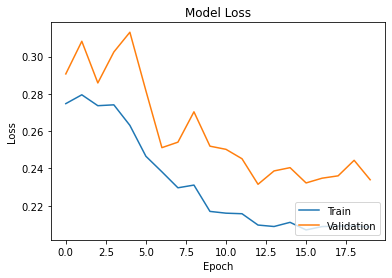

In [122]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#Adding title and labels to x and y axis
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#Adding title and labels to x and y axis
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [123]:
loss,accuracy,precision,recall,auc = model.evaluate(test_set)

106/106 [==============================] - 19s 176ms/step - loss: 0.1577 - accuracy: 0.9521 - precision: 0.9514 - recall: 0.9523 - auc: 0.9875


In [124]:
print(f"Test accuracy: {accuracy:.4f}")
print(f"Test precision: {precision:.4f}")
print(f"Test recall: {recall:.4f}")
print(f"Test AUC: {auc:.4f}")

Test accuracy: 0.9521
Test precision: 0.9514
Test recall: 0.9523
Test AUC: 0.9875


In [125]:
model.save('model.h5')

C:\Users\Chait\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
